# SDR Codebook optimization

## Setup

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json

from sionna.rt import Antenna

from cissir.physics import pow2db, db2power, mag2db, db2mag

from cissir import params, optimization as opt
from cissir.beamforming import dft_codebook, plot_beamforming_polar
from cissir.raytracing import si_paths2cir
from cissir.utils import PrintBuffer, plot_path, res_path
from cissir import visualization as viz
viz.paper_style(line_cycler=False, figsize=(1.5 * viz.def_figsize[0], 1.5 * viz.def_figsize[1]))


In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

# Number of beams
L_r = params.num_beams
L_t = params.num_beams

### DFT beam codebook


In [3]:
dft_tx_codebook, tx_degs = dft_codebook(L_max = L_t , N1 = N_t, full_grid=True,
                                          az_min = -60, az_max = 60, transmit=True)
L_t = len(tx_degs)
dft_rx_codebook, rx_degs = dft_codebook(L_max = L_r , N1 = N_r, full_grid=True,
                                          az_min = -60, az_max = 60, transmit=False)
L_r = len(rx_degs)

In [9]:
si_num_taps = 1 # "full"    # Options: 1, 2, "full"

def cb_si_db(tx_codebook, rx_codebook, si_channel):
    return mag2db(opt.codebook_si(tx_codebook, rx_codebook, si_channel))

with np.load(res_path/"channel_impulse_responses.npz") as rt_data:
    t_rt = np.squeeze(rt_data['t_channel_s'])
    ht_si_full = np.squeeze(rt_data['ht_si'])
    h_full = si_paths2cir(ht_si_full)

if si_num_taps == "full":
    h_si = h_full
    si_db_ref = cb_si_db(dft_tx_codebook, dft_rx_codebook, h_si).max()
else:
    with np.load(res_path/"si_mimo.npz") as rt_data:
        h_si = rt_data['h_si_matrix'][:si_num_taps]
    si_db_ref = cb_si_db(dft_tx_codebook, dft_rx_codebook,
                         si_paths2cir(ht_si_full[:si_num_taps])).max()
    h_si *= db2mag(si_db_ref - cb_si_db(dft_tx_codebook, dft_rx_codebook, h_si).max())
    
    assert h_si.shape == (si_num_taps, N_r, N_t), "Unexpected SI shape"

In [10]:
h_si_rx, h_si_tx = opt.si_split(h_si)

min_eigval_db = mag2db(opt.min_eigval(h_si))
max_eigval_db = mag2db(opt.max_eigval(h_si))

min_split_db = pow2db(opt.min_eigval(h_si_rx)*opt.min_eigval(h_si_tx))
max_split_db = pow2db(opt.max_eigval(h_si_rx)*opt.max_eigval(h_si_tx))

In [11]:
print(f"      eig_min H: {min_eigval_db:.1f} dB")
print(f"eig_min Grx\Gtx: {min_split_db:.1f} dB")
print(f"            cHw: {si_db_ref:.1f} dB")
print(f"      eig_max H: {max_eigval_db:.1f} dB")
print(f"eig_max Grx\Gtx: {max_split_db:.1f} dB")

      eig_min H: -173.9 dB
eig_min Grx\Gtx: -177.3 dB
            cHw: -60.6 dB
      eig_max H: -41.9 dB
eig_max Grx\Gtx: -41.4 dB


## Optimization

In [12]:
feasible_tolerance = 1e-2
tgt_si_values = np.arange(si_db_ref, min_split_db, -1.0)
pbuf = PrintBuffer(print_input=False)

In [13]:
rx_mesh, tx_mesh = np.meshgrid(rx_degs, tx_degs, indexing="ij")
beam_results = {"opt": "sdr",
                "taps": si_num_taps,
                "tx": {"degrees": tx_degs.tolist(),
                       "grid": tx_mesh.flatten().tolist()},
                "rx": {"degrees": rx_degs.tolist(),
                       "grid": rx_mesh.flatten().tolist()},
                "tgt_si": [],
                "ach_si": [],
                "spec_nuc_tx": [],
                "spec_nuc_rx": [],
                "beam_dev_tx": [],
                "beam_dev_rx": []
                }
results = []
codebooks = []

phased_array = True
sdrCodebooks = opt.SDRcodebook(h_si, dft_tx_codebook, dft_rx_codebook,
                               si_threshold_power=1.0, beta=0.5, phased=phased_array)
gram_beams_tx = sdrCodebooks.gram_codebook(dft_tx_codebook)
gram_beams_rx = sdrCodebooks.gram_codebook(dft_rx_codebook)


pbar = tqdm(tgt_si_values)
pbar.set_description(f"Baseline SI {si_db_ref:.1f} dB")
for tgt_si_db in pbar:
    
    att_db = -tgt_si_db
    tgt_si_pow = db2power(tgt_si_db)
    sdrCodebooks.si_threshold_power = tgt_si_pow
        
    pbuf.print(f"SI-ATT. {att_db:.1f} dB")

    try:
        start_time = time.perf_counter()
        w_codebook, W_sol = sdrCodebooks.solve(tx=True, return_sdr=True)
        c_codebook, C_sol = sdrCodebooks.solve(tx=False, return_sdr=True)
        end_time = time.perf_counter()
    except RuntimeError as re:
        print("Breaking loop due to runtime issues:")
        print(re)
        pbar.close()
        break

    si_db_sdr = mag2db(opt.sdr_si(W_sol, C_sol, h_si).max())
    loss_w_sdr = pow2db(max(opt.sdr_codebook_deviation(W_sol, gram_beams_tx), 1e-10))
    loss_c_sdr = pow2db(max(opt.sdr_codebook_deviation(C_sol, gram_beams_rx), 1e-10))
    
    max_c_err = opt.maxSdrError(C_sol, c_codebook)
    max_w_err = opt.maxSdrError(W_sol, w_codebook)
    max_amp_err = np.sqrt(max(max_c_err, max_w_err))

    si_db_matrix = cb_si_db(w_codebook, c_codebook, h_si)
    si_db_rank1 = np.max(si_db_matrix)
    tx_dev_beam = np.maximum(opt.codebook_deviation_power(dft_tx_codebook, w_codebook, axis=0), 1e-10)
    rx_dev_beam = np.maximum(opt.codebook_deviation_power(dft_rx_codebook, c_codebook, axis=0), 1e-10)
    loss_w_rank1 = pow2db(np.mean(tx_dev_beam))
    loss_c_rank1 = pow2db(np.mean(rx_dev_beam))
    
    att_sdr = -si_db_sdr
    att_rank1 = -si_db_rank1

    pbuf.print("Solutions SDR\\Rank-1:")
    pbuf.print(f"\t\tSI att.:\t{att_sdr:.1f}\\{att_rank1:.1f} dB\t({si_db_ref-si_db_rank1:.1f} dB from baseline)")
    pbuf.print(f"\t\tTx error:\t{loss_w_sdr:.1f}\\{loss_w_rank1:.1f} dB")
    pbuf.print(f"\t\tRx error:\t{loss_c_sdr:.1f}\\{loss_c_rank1:.1f} dB")
    pbuf.print(f"\tMax sol. error {max_amp_err:.2E}")
    
    postfix = (f"SI Tgt::Actual {att_db:.1f}::{att_rank1:.1f} dB; "
               f"Error Tx::Rx {loss_w_rank1:.1f}::{loss_c_rank1:.1f} dB; "
               f"Max sol. error {max_amp_err:.2E}")
    pbar.set_postfix_str(postfix)

    if si_num_taps == "full":
        att_full_db = att_rank1
    else:
        si_db_full = mag2db(np.max(opt.codebook_si(w_codebook, c_codebook, h_full)))
        att_full_db =  - si_db_full

    if max_amp_err < feasible_tolerance:
        codebooks.append({"att_tgt": att_db, "att_opt": att_rank1, "rx_codebook_p": c_codebook, "tx_codebook_p": w_codebook})
        tx_beam_db = pow2db(tx_dev_beam)
        rx_beam_db = pow2db(rx_dev_beam)
    else:
        att_rank1 = None
        att_full_db = None
        loss_w_rank1= None
        loss_c_rank1= None
        si_db_matrix[:] = np.nan
        tx_beam_db = np.full_like(tx_dev_beam, np.nan)
        rx_beam_db = np.full_like(rx_dev_beam, np.nan)

    beam_results["tgt_si"].append(-att_db)
    beam_results["ach_si"].append(si_db_matrix.flatten().tolist())
    beam_results["spec_nuc_tx"].append(opt.spec_nuc_ratio(W_sol).tolist())
    beam_results["spec_nuc_rx"].append(opt.spec_nuc_ratio(C_sol).tolist())
    beam_results["beam_dev_tx"].append(tx_beam_db.tolist())
    beam_results["beam_dev_rx"].append(rx_beam_db.tolist())

    results.append({"att_tgt": att_db, "opt": "sdp", "rx_sdr_err": max_c_err, "tx_sdr_err": max_w_err,
                    "att_opt": att_rank1, "tx_loss": loss_w_rank1, "rx_loss": loss_c_rank1, "elapsed_time": end_time - start_time,
                    "att_sdr": att_sdr, "tx_loss_sdr": loss_w_sdr, "rx_loss_sdr": loss_c_sdr, "att_full": att_full_db,
                    "phased": phased_array, "si_taps": si_num_taps, "num_beams": L_t})

  0%|          | 0/117 [00:00<?, ?it/s]

Breaking loop due to runtime issues:
The TX problem is infeasible, try increasing the target SI


In [14]:
pbuf.print()

SI-ATT. 60.6 dB
Solutions SDR\Rank-1:
		SI att.:	60.6\60.6 dB	(0.0 dB from baseline)
		Tx error:	-76.1\-90.3 dB
		Rx error:	-76.1\-90.2 dB
	Max sol. error 3.18E-03
SI-ATT. 61.6 dB
Solutions SDR\Rank-1:
		SI att.:	61.6\61.6 dB	(1.0 dB from baseline)
		Tx error:	-43.3\-43.3 dB
		Rx error:	-43.3\-43.3 dB
	Max sol. error 2.96E-03
SI-ATT. 62.6 dB
Solutions SDR\Rank-1:
		SI att.:	62.6\62.6 dB	(2.0 dB from baseline)
		Tx error:	-37.5\-37.5 dB
		Rx error:	-37.5\-37.5 dB
	Max sol. error 2.96E-03
SI-ATT. 63.6 dB
Solutions SDR\Rank-1:
		SI att.:	63.6\63.6 dB	(3.0 dB from baseline)
		Tx error:	-34.2\-34.2 dB
		Rx error:	-34.2\-34.2 dB
	Max sol. error 2.96E-03
SI-ATT. 64.6 dB
Solutions SDR\Rank-1:
		SI att.:	64.6\64.6 dB	(4.0 dB from baseline)
		Tx error:	-31.9\-31.9 dB
		Rx error:	-31.9\-31.9 dB
	Max sol. error 2.96E-03
SI-ATT. 65.6 dB
Solutions SDR\Rank-1:
		SI att.:	65.6\65.6 dB	(5.0 dB from baseline)
		Tx error:	-30.2\-30.2 dB
		Rx error:	-30.2\-30.2 dB
	Max sol. error 2.96E-03
SI-ATT. 66.6 dB


## Saving results

In [15]:
res_file = res_path/f"sdp_cb_results_phased_{si_num_taps}tap_si.csv"
res_df = pd.DataFrame(results)
res_df.to_csv(res_file)
print(f"Results saved under {res_file}")
json_fname = res_path/f"sdp_beam_results_{si_num_taps}tap.json"
with open(json_fname, 'w', encoding ='utf8') as json_file:
    json.dump(beam_results, json_file)
print(f"Results saved under {json_fname}")

Results saved under /mnt/project/results/sdp_cb_results_phased_1tap_si.csv
Results saved under /mnt/project/results/sdp_beam_results_1tap.json


In [16]:
method = f"sdp_ph_{si_num_taps}_{L_t}tx"

att_values = [-np.inf]
att_achieved = [-si_db_ref]
tx_codebooks = [dft_tx_codebook]
rx_codebooks = [dft_rx_codebook]
for cb in codebooks:
    att_values.append(cb["att_tgt"])
    att_achieved.append(cb["att_opt"])
    tx_codebooks.append(cb["tx_codebook_p"])
    rx_codebooks.append(cb["rx_codebook_p"])

att_values = np.array(att_values) 
tx_codebooks = np.stack(tx_codebooks, axis=0)
rx_codebooks = np.stack(rx_codebooks, axis=0)
tx_dev = np.array([-np.inf] + [r["tx_loss"] for r in results]).astype(float)
rx_dev = np.array([-np.inf] + [r["rx_loss"] for r in results]).astype(float)

metadata = np.array({"method": method, "phased": phased_array, "si_num_taps": si_num_taps,
                     "norm": "max"})
fname = f"{method}_codebooks.npz"
np.savez(res_path/fname, att_tgt=att_values,
         att_opt=att_achieved, tx_dev=tx_dev, rx_dev=rx_dev,
         rx_degrees=rx_degs, tx_degrees=tx_degs,
         rx=rx_codebooks, tx=tx_codebooks,
         metadata=metadata)
print(f"{fname} was saved at {res_path}.")

sdp_ph_1_27tx_codebooks.npz was saved at /mnt/project/results.


## Plot

In [22]:
with np.load(res_path/"sdp_ph_full_27tx_codebooks.npz") as cb_data:
    att_achieved = cb_data["att_opt"]
    att_values = cb_data["att_tgt"]
    tx_codebooks = cb_data["tx"]
    L_t = tx_codebooks.shape[-1]
    rx_codebooks = cb_data["rx"]
    L_r = rx_codebooks.shape[-1]

    tx_dev = cb_data["tx_dev"]
    rx_dev = cb_data["rx_dev"]

    tx_degs = cb_data["tx_degrees"]
    rx_degs = cb_data["rx_degrees"]
    beam_degs = tx_degs

In [23]:
plot_att = 100
att_index = np.argmin(np.abs(np.array(att_values) - plot_att))
att_db_val = att_values[att_index]
tx_dev_val = tx_dev[att_index]
opt_tx_codebook = tx_codebooks[att_index,]
opt_rx_codebook = rx_codebooks[att_index,]

In [24]:
antenna_pattern = Antenna(params.antenna_pattern, polarization=params.antenna_polarization).patterns
rad_pattern = lambda x: sum(sum(np.abs(p)**2 for p in pat(np.pi/2, x)) for pat in antenna_pattern)

In [25]:
att_db_val

100.48768567077357

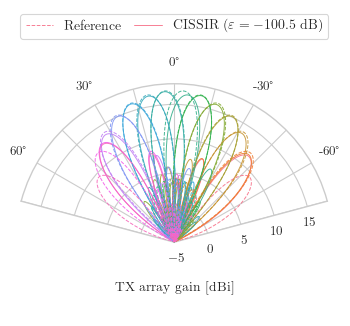

In [26]:
f, ax = plt.subplots(subplot_kw={'projection': 'polar'})

thetas = np.deg2rad(np.arange(-75, 80, 15))
offset, stride = 0, 2

tx_kwargs = dict(transmit=True, element_pattern=rad_pattern, axis=ax, r_lim=(-5, 18), alpha=0.9, linewidth=0.7, theta_lim=(-5*np.pi/12, 5*np.pi/12))
_ = plot_beamforming_polar(dft_tx_codebook[:, offset::stride], linestyle="--", color_palette="husl", **tx_kwargs, label="Reference", zorder=20)
_ = plot_beamforming_polar(opt_tx_codebook[:, offset::stride], color_palette="husl", **tx_kwargs,
                           label="Optimized", zorder=10)

ax.set_xticks(thetas)
xticks = ax.get_xticklabels()
_ = ax.set_xticklabels([tick if i % 2 == 1 else None for i, tick in enumerate(xticks)])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:1]+handles[L_t//stride+1:L_t//stride+2],
          ["Reference", rf"CISSIR ($\varepsilon=-{att_db_val:.1f}$ dB)"],
          loc="upper center", ncol=2, prop={'size': 10},
          columnspacing=0.8, bbox_to_anchor=(0.5, 1.01))
ax.set_xlabel("TX array gain [dBi]")
ax.xaxis.labelpad = -25

f.savefig(plot_path/"beams.pdf", bbox_inches="tight", pad_inches=0)
f.savefig(plot_path/"beams.pgf", bbox_inches="tight", pad_inches=0)
